In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score

from sklearn.linear_model import LinearRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
import matplotlib
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
### 데이터 불러오기 ###
df = pd.read_csv('Data/교통사망사고정보/original_kor.csv',encoding='CP949')
#df.drop(['temp1','temp2','temp3','발생분변환'],axis=1,inplace=True)

# 충남 연기군 -> 세종 세종 변경 (12년 7월)
df.loc[df.발생지시군구=='연기군','발생지시군구']='세종'
df.loc[(df.발생지시도=='충남')&(df.발생지시군구=='세종'),'발생지시도']='세종'

# 충북 청원군 -> 충북 청주시 변경 (14년 7월)
df.loc[df.발생지시군구=='청원군','발생지시군구']='청주시'

# 총부상자수 변수
df['총부상자수']=df.사상자수 - df.사망자수

# 기상데이터

여러 신문기사, 연구결과에 의하면, 날씨도 교통사고에 큰 영향을 미친다고 함. 이에 특히 교통사고의 피해정도가 높은 날씨가 있는지 날씨별로 사고위험도를 계산해봄

In [5]:
df_sun = pd.read_csv('Data/추가데이터/safe_sun.csv')
df_sun

,분류,12,13,14,15,16,평균
0,합계,4.91,4.86,4.78,4.77,4.74,4.81
1,기타,4.78,4.61,4.31,4.46,4.49,4.53
2,맑음,4.85,4.82,4.74,4.73,4.70,4.77
3,비,5.17,5.09,5.07,4.95,4.91,5.04
4,흐림,5.23,5.12,5.04,5.04,5.12,5.11
5,눈,5.54,5.87,5.29,5.54,5.68,5.58
6,안개,6.46,6.74,6.10,7.39,7.17,6.77


In [6]:
df_sun['차이']=df_sun.평균-4.81
df_sun

,분류,12,13,14,15,16,평균,차이
0,합계,4.91,4.86,4.78,4.77,4.74,4.81,0.00
1,기타,4.78,4.61,4.31,4.46,4.49,4.53,-0.28
2,맑음,4.85,4.82,4.74,4.73,4.70,4.77,-0.04
3,비,5.17,5.09,5.07,4.95,4.91,5.04,0.23
4,흐림,5.23,5.12,5.04,5.04,5.12,5.11,0.30
5,눈,5.54,5.87,5.29,5.54,5.68,5.58,0.77
6,안개,6.46,6.74,6.10,7.39,7.17,6.77,1.96


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


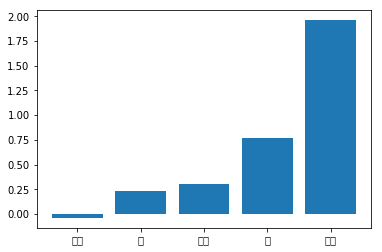

In [7]:
ind = np.arange(df_sun.shape[0]-2)

plt.bar(ind, df_sun.차이[2:])
plt.xticks(ind, np.array(df_sun.분류[2:]));

전체 평균 위험도인 4.81과의 차이를 보면, 안개낀 날 사고들의 사고위험도는 2정도 더 높은 6.77이고, 눈내리는 날 사고들의 사고위험도는 0.75정도 더 높은 5.58정도이다.      
               
이에 특히 사고가 났을때 피해가 높은 날씨가 있을 것이라고 판단해서, 시군구별 평균 강수량, 평균 강우량, 평균 안개일수를 찾아서 변수로 넣고자 했음. 하지만 기상청 데이터가 시군구가 아닌 시도 단위로만 데이터를 제공하는 것 같아서 구하지 못했음. 시도 단위는 너무 넓어서, 특정 지역의 기상특징을 잘 잡아내지 못해서 시도단위의 날씨 관련 변수는 의미 없다고 생각.

# 도로 데이터

대형교통사고들은 주로 차량평균속도가 높은 고속도로나 큰 도로에서 발생하지 않을까 생각. 그래서 도로별 사고위험도를 계산해봄.

In [8]:
df_도로=pd.read_csv('Data/추가데이터/safe_road.csv')
df_도로

,도로유형,2012,2013,2014,2015,2016,평균
0,합계,4.91,4.86,4.78,4.77,4.74,4.81
1,기타,4.00,3.97,3.87,3.85,3.80,3.90
2,특별광역시도,4.60,4.59,4.53,4.50,4.47,4.64
3,시도,4.82,4.81,4.78,4.73,4.74,4.78
4,지방도,5.34,5.29,5.12,5.18,5.12,5.21
5,일반국도,6.19,6.22,6.00,5.94,5.70,6.01
6,고속국도,8.30,8.25,8.10,7.99,7.87,8.10


In [9]:
df_도로['차이']=df_도로.평균-4.81
temp = df_도로[['도로유형','차이']]
temp = temp[2:]
temp

,도로유형,차이
2,특별광역시도,-0.17
3,시도,-0.03
4,지방도,0.40
5,일반국도,1.20
6,고속국도,3.29


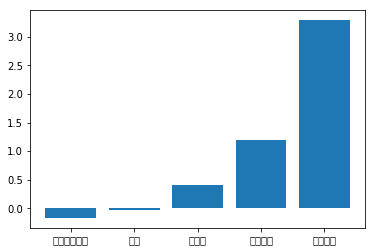

In [10]:
ind = np.arange(temp.shape[0])

plt.bar(ind,temp.차이)
plt.xticks(ind, np.array(temp.도로유형));

전체 평균 위험도인 4.81과의 차이를 보면, 고속도로에서 발생하는 사고들의 사고위험도는 3.29정도 더 높은 8.1이고, 일반국도에서 발생하는 사고들의 사고위험도는 1.25정도 더 높은 6.01정도이다.      
               
이에 특히 사고가 났을때 피해가 높은 고속국도는 시군구별 고속국도길이를 찾아서 변수로 넣고자 함.

In [12]:
# df_high = pd.read_csv('highway.csv',encoding='CP949')
# df_high.fillna(0,inplace=True)

# df_high

이 데이터를 기존 train data에 합치는 작업은 희준님이 해주셨습니다. 